# Curating taxonomy using tax2tree

[**tax2tree**](https://github.com/wasade/tax2tree) ([McDonald et al., 2012](https://www.nature.com/articles/ismej2011139)) automatically curates taxonomic annotations of tree tips and internal nodes based on tree topology. This notebook explains how tax2tree is executed and parses its output files to generate more information.

## Usage of tax2tree

### Installation

```conda create -n tax2tree numpy Click future==0.13.1 scikit-bio==0.2.3 python=2
source activate tax2tree
pip install git+https://github.com/wasade/tax2tree.git
source activate tax2tree```

### Input files

A tree in Newick format:

In [1]:
!cat tree.nwk | cut -c1-400

((((G000830275,G000402355)N8:1.380276217937432,(G000830295,G001871415)N9:0.3229406720234299)N4:0.3513445134276098,((((G001940645,(G001940755,G001940725)N42:0.0861855240487885)N25:0.33699296079495406,(G001940655,(G001563325,(G001563335,G001940705)N67:1.0079577138891038)N43:1.137424498768485)N26:0.08418174824796781)N15:0.06949376998728227,(((G001515215,G001515205)N44:1.0827559306916261,((G001587675,


A genome ID to lineage str (taxa at the seven ranks) map:

In [2]:
!head -n5 lineages.txt | cut -c1-100

G000005825	k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae_D; g__Bacillus_S; s
G000006175	k__Archaea; p__Euryarchaeota; c__Methanococci; o__Methanococcales; f__Methanococcaceae; g
G000006605	k__Bacteria; p__Actinobacteriota; c__Actinobacteria; o__Corynebacteriales; f__Corynebacte
G000006725	k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Xanthomonadales; f__Xanthomona
G000006745	k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacterales; f__Vibrionac


### Run tax2tree

Decorate the tree with taxonomy.

```t2t decorate -t tree.nwk -m lineages.txt -o decorated.nwk > tax2tree.stdout
mv decorated.nwk-consensus-strings consensus_strings.txt```

Assess the consistency between taxdump and topology.

```t2t consistency -t tree.nwk -m lineages.txt -o consistency.tsv >> tax2tree.stdout```

### Output files

Tree with selected nodes decorated with lineage strings:

In [3]:
!cat decorated.nwk | cut -c1-400

((((G000830275,G000402355)'p__Micrarchaeota_2; c__Iainarchaeia; o__Iainarchaeales':1.38027621794,(G000830295,G001871415)'p__Nanoarchaeota; c__Woesearchaeia':0.322940672023):0.351344513428,((((G001940645,(G001940755,G001940725):0.0861855240488)'c__Heimdallarchaeia':0.336992960795,(G001940655,(G001563325,(G001563335,G001940705):1.00795771389)'f__Thorarchaeaceae':1.13742449877)'c__Lokiarchaeia; o__Th


Consensus strings (taxon to lineage map):

In [4]:
!head -n5 consensus_strings.txt

G000830275	k__Archaea; p__Micrarchaeota_2; c__Iainarchaeia; o__Iainarchaeales; f__; g__; s__
G000402355	k__Archaea; p__Micrarchaeota_2; c__Iainarchaeia; o__Iainarchaeales; f__; g__; s__
G000830295	k__Archaea; p__Nanoarchaeota; c__Woesearchaeia; o__; f__; g__; s__
G001871415	k__Archaea; p__Nanoarchaeota; c__Woesearchaeia; o__; f__; g__; s__
G001940645	k__Archaea; p__Asgardarchaeota; c__Heimdallarchaeia; o__; f__; g__; s__


Consistency analysis result:

In [5]:
!head -n5 consistency.tsv

Taxon	Count	Consistency
k__Archaea	645	1.000
k__Bacteria	9086	1.000
p__Hydrogenedentota	3	1.000
p__SM23-31	1	1.000


## Preparation

### Dependencies

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from skbio import TreeNode

In [8]:
%matplotlib inline

### Input files

Original tree (with unique internal node IDs).

In [9]:
tree_ori_fp = 'tree.nwk'

Decorated tree (internal node IDs removed and some nodes appended lineage strings).

In [10]:
tree_dec_fp = 'decorated.nwk'

Original genome to lineage map.

In [11]:
lineage_ori_fp = 'lineages.txt'

Consensus strings (genom to lineage string map).

In [12]:
cons_str_fp = 'consensus_strings.txt'

Consistency analysis result.

In [13]:
consist_fp = 'consistency.tsv'

### Parameters

Ranks and codes.

In [14]:
ranks = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
code2rank = {x[0]: x for x in ranks}

### Utilities

Read genome to lineage map into dataframe.

In [15]:
def lineages_to_df(lineage_fp):
    g2lin = {}
    with open(lineage_fp, 'r') as f:
        for line in f:
            g, lineage = line.rstrip('\r\n').split('\t')
            g2lin[g] = dict(zip(ranks, [x.split('__')[1] for x in lineage.split('; ')]))
    df = pd.DataFrame.from_dict(g2lin, orient='index')
    return df.loc[sorted(g2lin, key=lambda x: int(x[1:]))]

Export by-rank dataframe as lineage strings.

In [16]:
def df_to_lineages(df, f):
    for row in df.itertuples():
        lin = []
        for i, rank in enumerate(ranks):
            lin.append('%s__%s' % (rank[0], row[i + 1]))
        f.write('%s\t%s\n' % (row.Index, '; '.join(lin)))

## Analysis

### Curated taxonomy

Read consensus strings.

In [17]:
dfc = lineages_to_df(cons_str_fp)
dfc.head()

,kingdom,phylum,class,order,family,genus,species
G000005825,Bacteria,Firmicutes,Bacilli,Bacillales_3,Bacillaceae_D,,
G000006175,Archaea,Euryarchaeota_1,Methanococci,Methanococcales,Methanococcaceae,Methanococcus,
G000006605,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Corynebacteriaceae,Corynebacterium,
G000006725,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xylella,
G000006745,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio,


Note: In tax2tree's assumption, all lineages should be continuous (i.e., a continuous series of ranks should all contain taxa). However in reality some lineages contain caps. For example:

`G001458535 k__Bacteria; p__Candidatus Kryptonia; c__; o__; f__; g__Candidatus Kryptonium; s__Candidatus Kryptonium thompsoni`

In those cases tax2tree may produced gapped consensus strings.

Convert to table.

In [18]:
dfc.to_csv('consensus_ranks.tsv', sep='\t')

### Analyze polytomies

Taxon names ending with `__#` are the ones identified as polytomies and split into multiple taxa by tax2tree.

In [19]:
splits = {}
for rank in ranks:
    split_names = {}
    for name in set(x for x in dfc[rank] if x):
        x = name.split('_')
        # convert "taxonA_1" into "taxonA"
        if len(x) > 1 and x[-1].isdigit():
            ori_name = '_'.join(x[:-1])
            # get all appended indices for each taxon
            if ori_name in split_names:
                split_names[ori_name].append(int(x[-1]))
            else:
                split_names[ori_name] = [int(x[-1])]

    splits[rank] = {}
    for name in sorted(split_names):
        indices = split_names[name]
        # check if the indices are incremental integers
        if sorted(indices) != list(range(1, max(indices) + 1)):
            print('%s: %s is not a split.' % (rank, name))
            continue
        splits[rank][name] = len(indices)

Get original names that appear in the curated table.

In [20]:
ori_names = {}
for rank in ranks:
    ori_names[rank] = set()
    for name in set(x for x in dfc[rank] if x):
        x = name.split('_')
        if len(x) > 1 and x[-1].isdigit():
            name_ = '_'.join(x[:-1])
            if name_ in splits[rank]:
                ori_names[rank].add(name_)
            else:
                ori_names[rank].add(name)
        else:
            ori_names[rank].add(name)
print(', '.join('%s: %d' % (x, len(ori_names[x])) for x in ranks))

kingdom: 2, phylum: 69, class: 157, order: 347, family: 683, genus: 1443, species: 748


Export results.

In [21]:
with open('split_taxa.tsv', 'w') as f:
    f.write('rank\ttaxon\tsplits\n')
    for rank in ranks:
        d = splits[rank]
        if len(d) > 0:
            max_name = max(d.keys(), key=(lambda k: d[k]))
            print('%s: %d taxa split, max = %s (%s)'
                  % (rank, len(d), d[max_name], max_name))
            for name in sorted(d):
                f.write('%s\t%s\t%d\n' % (rank, name, d[name]))

phylum: 3 taxa split, max = 2 (Desulfobacterota)
class: 4 taxa split, max = 2 (Elusimicrobia)
order: 2 taxa split, max = 5 (Bacillales)
family: 2 taxa split, max = 2 (Cyanobacteriaceae)


### Analyze consistency

In [22]:
dfp = pd.read_csv(consist_fp, sep='\t')
dfp.head()

,Taxon,Count,Consistency
0,k__Archaea,645,1.0
1,k__Bacteria,9086,1.0
2,p__Hydrogenedentota,3,1.0
3,p__SM23-31,1,1.0
4,p__Elusimicrobiota,27,1.0


In [23]:
dfp['Name'] = dfp['Taxon'].str.split('__').str.get(1)
dfp['Rank'] = dfp['Taxon'].str.split('__').str.get(0).map(code2rank)
dfp.set_index('Taxon', inplace=True)
dfp.head()

,Count,Consistency,Name,Rank
Taxon,,,,
k__Archaea,645,1.0,Archaea,kingdom
k__Bacteria,9086,1.0,Bacteria,kingdom
p__Hydrogenedentota,3,1.0,Hydrogenedentota,phylum
p__SM23-31,1,1.0,SM23-31,phylum
p__Elusimicrobiota,27,1.0,Elusimicrobiota,phylum


(0.8, 1.05)

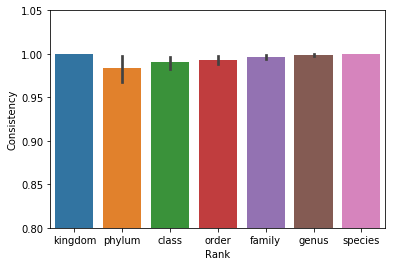

In [24]:
fig, ax = plt.subplots()
sns.barplot(x='Rank', y='Consistency', data=dfp, ax=ax)
ax.set_ylim(0.8,)

In [25]:
fig.tight_layout()
fig.savefig('consistency.pdf', bbox_inches='tight')

### Fill spaces with unique taxa

tax2tree-curated taxa are the ones that occur more than once in the table. However many genomes are the only representatives of some taxa, especially the species level. Therefore, the empty cells will be filled with unique taxa when applicable.

Note the those added taxa are NOT tax2tree-curated taxa. They are but unique identifiers of certain genomes.

Read original lineages.

In [26]:
dfo = lineages_to_df(lineage_ori_fp)
dfo.head()

,kingdom,phylum,class,order,family,genus,species
G000005825,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae_D,Bacillus_S,Bacillus_S pseudofirmus
G000006175,Archaea,Euryarchaeota,Methanococci,Methanococcales,Methanococcaceae,Methanococcus,Methanococcus voltae
G000006605,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Corynebacteriaceae,Corynebacterium,Corynebacterium jeikeium
G000006725,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xylella,Xylella fastidiosa
G000006745,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio,Vibrio cholerae


Identify taxa from the original lineages that can be filled to trailing spaces following consensus strings.

In [27]:
taxa_to_add = {x: {} for x in ranks}
for g in dfc.index:
    for rank in ranks:
        if dfc[rank][g] == '' and g in dfo.index:
            taxon = dfo[rank][g]
            if taxon != '' and not taxon in ori_names[rank]:
                taxa_to_add[rank][g] = taxon
print(', '.join('%s: %d' % (x, len(taxa_to_add[x])) for x in ranks))

kingdom: 0, phylum: 20, class: 39, order: 133, family: 377, genus: 2033, species: 4751


Exclude taxa that occur multiple times at each rank.

In [28]:
for rank in ranks:
    used, dups = set(), set()
    for g, taxon in taxa_to_add[rank].items():
        if taxon in used:
            dups.add(taxon)
        used.add(taxon)
    new_dict = {}
    for g, taxon in taxa_to_add[rank].items():
        if taxon not in dups:
            new_dict[g] = taxon
    taxa_to_add[rank] = new_dict
print(', '.join('%s: %d' % (x, len(taxa_to_add[x])) for x in ranks))

kingdom: 0, phylum: 20, class: 39, order: 125, family: 367, genus: 2027, species: 4749


Add those taxa to the lineage table.

In [29]:
dfl = dfc.copy(deep=True)
for i, rank in enumerate(ranks):
    for g, taxon in taxa_to_add[rank].items():
        dfl[rank][g] = taxon
dfl.head()

,kingdom,phylum,class,order,family,genus,species
G000005825,Bacteria,Firmicutes,Bacilli,Bacillales_3,Bacillaceae_D,Bacillus_S,Bacillus_S pseudofirmus
G000006175,Archaea,Euryarchaeota_1,Methanococci,Methanococcales,Methanococcaceae,Methanococcus,Methanococcus voltae
G000006605,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Corynebacteriaceae,Corynebacterium,Corynebacterium jeikeium
G000006725,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xylella,Xylella fastidiosa
G000006745,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio,Vibrio cholerae


In [30]:
dfl.to_csv('filled_ranks.tsv', sep='\t')

In [31]:
with open('filled_lineages.txt', 'w') as f:
    df_to_lineages(dfl, f)

### Analyze node decoration

Match decorations and node IDs.

In [32]:
tree_ori = TreeNode.read(tree_ori_fp)
tree_ori.count(tips=True)

10575

In [33]:
tree_dec = TreeNode.read(tree_dec_fp)
tree_dec.count(tips=True)

10575

Confirm that the decorated tree has the same topology and order of taxa as the original tree.

In [34]:
tree_ori.compare_rfd(tree_dec)

0.0

Read internal node IDs from the original tree.

In [35]:
nids = []
for node in tree_ori.levelorder():
    if not node.is_tip():
        nids.append(node.name)

Read node decorations.

In [36]:
decos = []
for node in tree_dec.levelorder():
    if not node.is_tip():
        decos.append(node.name)
decos[:5]

[None, 'k__Archaea', 'k__Bacteria', None, None]

Generate a rank name table.

In [37]:
nid2label = {}
nid2ranks = {}
for i in range(len(nids)):
    nid = nids[i]
    deco = decos[i]
    nid2ranks[nid] = {x: '' for x in ranks}
    if deco is not None and '__' in deco:
        deco = deco.split(':')[-1]  # remove node support in case there is one
        nid2label[nid] = deco
        for taxon in deco.split('; '):
            code, name = taxon.split('__')
            nid2ranks[nid][code2rank[code]] = name

In [38]:
with open('decorations.txt', 'w') as f:
    for nid in sorted(nid2label, key=lambda x: int(x.lstrip('N'))):
        f.write('%s\t%s\n' % (nid, nid2label[nid]))

In [39]:
dfd = pd.DataFrame.from_dict(nid2ranks, orient='index')
dfd = dfd.loc[sorted(nid2ranks, key=lambda x: int(x[1:]))]
dfd.head()

,kingdom,phylum,class,order,family,genus,species
N1,,,,,,,
N2,Archaea,,,,,,
N3,Bacteria,,,,,,
N4,,,,,,,
N5,,,,,,,


In [40]:
dfd.to_csv('decorations_by_rank.tsv', sep='\t')

### Generate lineage for every node

At a given node, at each rank, check if one taxon can describe all descendants.

In [41]:
g2ranks = dfl.to_dict('index')

In [42]:
nid2ranks, nid2lineage = {}, {}
for nid in nids:
    nid2ranks[nid] = {x: '' for x in ranks}
    nid2lineage[nid] = []
    gs = tree_ori.find(nid).subset()
    for rank in ranks:
        nid2lineage[nid].append('%s__' % rank[0])
        names = set(g2ranks[x][rank] for x in gs)
        if len(names) == 1:
            name = max(names)
            nid2ranks[nid][rank] = name
            nid2lineage[nid][-1] += name

In [43]:
with open('node_lineages.txt', 'w') as f:
    for nid in sorted(nid2lineage, key=lambda x: int(x[1:])):
        f.write('%s\t%s\n' % (nid, '; '.join(nid2lineage[nid])))

In [44]:
dfn = pd.DataFrame.from_dict(nid2ranks, orient='index')
dfn = dfn.loc[sorted(nid2ranks, key=lambda x: int(x[1:]))]
dfn.head()

,kingdom,phylum,class,order,family,genus,species
N1,,,,,,,
N2,Archaea,,,,,,
N3,Bacteria,,,,,,
N4,Archaea,,,,,,
N5,Archaea,,,,,,


In [45]:
dfn.to_csv('node_ranks.tsv', sep='\t')